In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from collections import Counter

In [2]:
def likelihood(theta, N, K):
    print('Theta:', theta)
    print('N:', N)
    print('K:', K)
    result = 1
    for k in range(K):
        if N[k]:
            result *= theta[k] ** N[k]
    return result
    
def prior(theta, K, concentration):
    result = 1
    for k in range(K):
        result *= theta[k] ** (concentration[k]-1)
    return result

def posterior(theta, N, K, concentration):
    result = 1
    for k in range(K):
        result *= theta[k] ** (concentration[k] + N[k] - 1)
    return result
    
def count_likelihood(domain):
    counter = Counter(domain)
    return counter
#     result = []
#     for c,x in counter.items():
#         result.append(x)
#     return result 

Theta: [3.66855881e-02 1.41575073e-12 9.62842094e-01 4.72317947e-04
 8.46662999e-13 6.38817333e-15]
N: Counter({4: 5, 2: 2, 3: 2, 5: 1})
K: 2


<Container object of 6 artists>

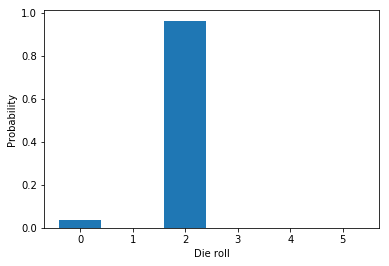

In [3]:
K = 2
N = 10
theta = np.random.dirichlet([np.random.random()] * 6)
domain = []
for _ in range(N):
    domain.append(np.random.randint(1,6))
likelihood_map = count_likelihood(domain)
concentration_parameter = []
for _ in range(N):
    concentration_parameter.append(np.random.randint(1,20))
likelihood_result = likelihood(theta, likelihood_map, K)
prior_result = prior(theta, K, concentration_parameter)
posterior_result = posterior(theta, likelihood_map, K, concentration_parameter)

plt.xlabel('Die roll')
plt.ylabel('Probability')
plt.bar(range(6), theta)

In [4]:
posterior_result

1.3318368159121326e-31

In [5]:
def posterior_predictive(concentration, N, j):
    denominator = 0
    for k in range(K):
        denominator += concentration[k] + N[k]
    numerator = concentration[j] + N[j]
    return numerator / denominator

In [6]:
posterior_predictive(concentration_parameter, likelihood_map, 2)

0.7777777777777778

In [7]:
import spacy
nlp = spacy.load('en')

doc = nlp(u"Apples and oranges are similar. Boots and hippos aren't.")

for token in doc:
    print(token, token.lemma, token.lemma_)

OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.